importar librerias

In [ ]:
import zipfile #sirve para manejar zip
import os # trabajar co el SO

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import cv2

In [ ]:
zip_path = "/content/DetectorDeHerramientas.zip"
extract_path = "/content/extracted_files"

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
def rgb_to_grayscale_to_rgb(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #copnvierte a grises
  gray = np.expand_dims(img, axis=1)
  gray_rgb = np.repeat(img, 3, axis=2)
  return gray_rgb.astype('float32')


def preprocess_input(img):
  img = img.astype('float32') / 255.0
  return img



configuracion del generador de datos

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 15,
    zoom_range = 0.1,
    width_shift_range=0.05,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)




carga de imagenes desde las carptas

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/extracted_files/DetectorDeHerramientas',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset = 'training',
    shuffle = True
    )

val_generator = train_datagen.flow_from_directory(
    '/content/extracted_files/DetectorDeHerramientas',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset = 'validation',
    shuffle = False
    )


Found 5499 images belonging to 23 classes.
Found 1365 images belonging to 23 classes.


carga del modelo preentrenado MobileNetV2

In [ ]:
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"

In [ ]:
base_model = hub.KerasLayer(model_url, input_shape=(128, 128, 3), trainable=False)


callbacks para control dinamico

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    factor = 0.2,
    min_lr=1e-6
)

construccion del modelo

In [ ]:
def apply_hub_layer(x):
  return base_model(x)

In [ ]:
input_layer = Input(shape=(128, 128, 3))
x = tf.keras.layers.Lambda(apply_hub_layer, output_shape=(1001,), name= "hub_lambda")(input_layer)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)




In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  8/172 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.0727 - loss: 3.3188

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 64s 312ms/step - accuracy: 0.4560 - loss: 1.8248 - val_accuracy: 0.7136 - val_loss: 0.9125 - learning_rate: 0.0010
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.7154 - loss: 0.8492 - val_accuracy: 0.7326 - val_loss: 0.8148 - learning_rate: 0.0010
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.7620 - loss: 0.6894 - val_accuracy: 0.7480 - val_loss: 0.8273 - learning_rate: 0.0010
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.8046 - loss: 0.5747 - val_accuracy: 0.7582 - val_loss: 0.7720 - learning_rate: 0.0010
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.8285 - loss: 0.5047 - val_accuracy: 0.7817 - val_loss: 0.7768 - learning_rate: 0.0010
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.8428 - loss: 0.4432 - val_accuracy: 0.7634 - val_loss: 0.8519 - learning_rate: 0.0010
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step - accuracy: 0.8528 - loss:

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 57s 304ms/step - accuracy: 0.8926 - loss: 0.3082 - val_accuracy: 0.8161 - val_loss: 0.6570 - learning_rate: 1.0000e-04
Epoch 2/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.9097 - loss: 0.2594 - val_accuracy: 0.8088 - val_loss: 0.6750 - learning_rate: 1.0000e-04
Epoch 3/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.9200 - loss: 0.2437 - val_accuracy: 0.8278 - val_loss: 0.6400 - learning_rate: 1.0000e-04
Epoch 4/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.9145 - loss: 0.2500 - val_accuracy: 0.8286 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 5/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 253ms/step - accuracy: 0.9301 - loss: 0.2134 - val_accuracy: 0.8315 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 6/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.9191 - loss: 0.2357 - val_accuracy: 0.8249 - val_loss: 0.6571 - learning_rate: 1.0000e-04
Epoch 7/15
172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 25

In [ ]:
from google.colab import files
model.save('modelo_herramientasFullmasN.h5')
files.download('modelo_herramientasFullmasN.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 6/43 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - accuracy: 0.9441 - loss: 0.1684
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - accuracy: 0.8524 - loss: 0.5454
Train Loss: 0.1697
Train Accuracy: 0.9444
Test Loss: 0.6445
Test Accuracy: 0.8293


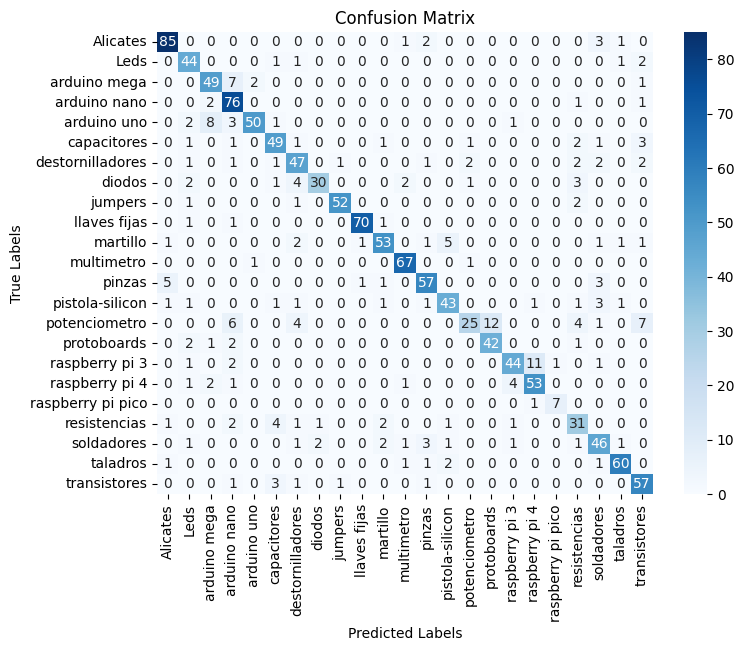

                   precision    recall  f1-score   support

         Alicates       0.90      0.92      0.91        92
             Leds       0.76      0.90      0.82        49
     arduino mega       0.79      0.83      0.81        59
     arduino nano       0.74      0.95      0.83        80
      arduino uno       0.94      0.77      0.85        65
      capacitores       0.80      0.82      0.81        60
 destornilladores       0.73      0.78      0.76        60
           diodos       0.91      0.70      0.79        43
          jumpers       0.96      0.93      0.95        56
     llaves fijas       0.97      0.96      0.97        73
         martillo       0.87      0.80      0.83        66
       multimetro       0.92      0.97      0.94        69
           pinzas       0.85      0.85      0.85        67
  pistola-silicon       0.83      0.78      0.80        55
    potenciometro       0.83      0.42      0.56        59
      protoboards       0.78      0.88      0.82       

In [ ]:
# prompt: sacame las metricas de mi modelo respecto al entrenamiento y respectoa pruebas y imprimeme la matris de confuicion y un reporte de clasificacion

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Calculate metrics
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(val_generator.class_indices.keys()),
            yticklabels=list(val_generator.class_indices.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
class_names = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))
